In [7]:
import warnings
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from scipy.ndimage import rotate, shift, zoom

warnings.filterwarnings('ignore')
%matplotlib inline

In [8]:
# Load dataset
mnist = fetch_openml('mnist_784', version=1, data_home='../data', as_frame=False)
data, labels = mnist['data'], mnist['target']

print(data.shape, labels.shape)

(70000, 784) (70000,)


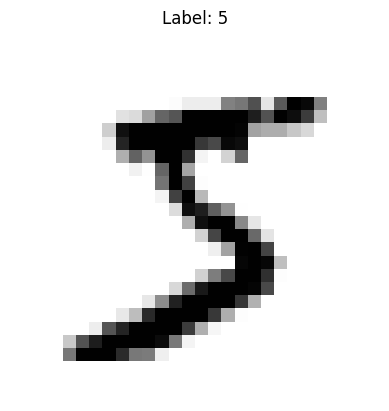

In [9]:
# Show a sample
sample_data = data[0]
sample_label = labels[0]
sample_data = sample_data.reshape(28, 28)
plt.imshow(sample_data, cmap='binary')
plt.title(f"Label: {sample_label}")
plt.axis('off')
plt.show()

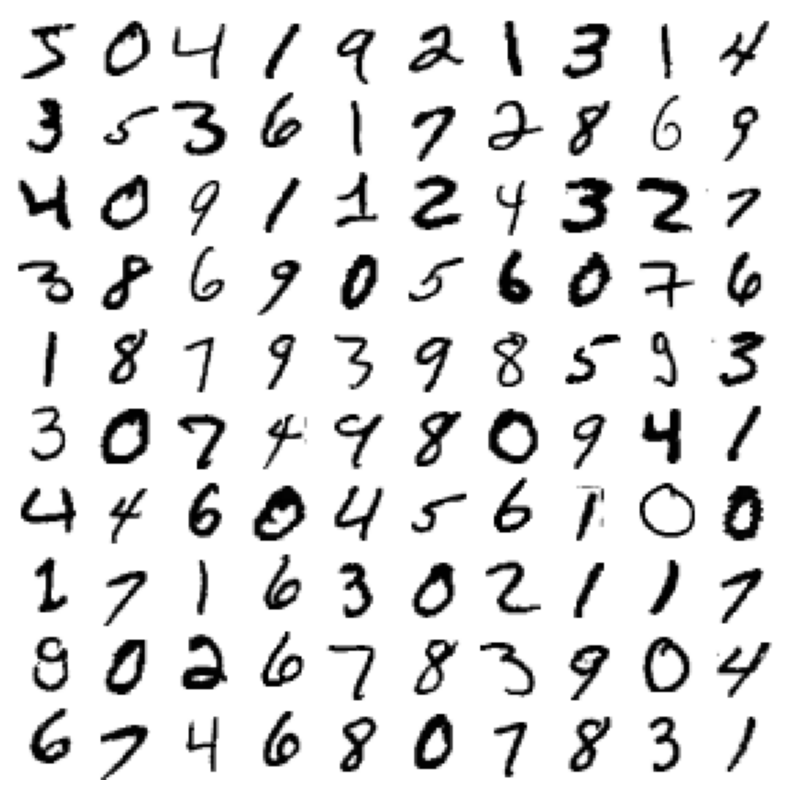

In [10]:
# Show some samples in grid

samples = data[:100]
samples = samples.reshape(10, 10, 28, 28)
samples = samples.transpose(0, 2, 1, 3)
samples = samples.reshape(280, 280)

plt.figure(figsize=(10, 10))
plt.imshow(samples, cmap='binary')
plt.axis('off')
plt.show()

In [11]:
# Implement some Augmentation Functions

def random_rotation(image):
  angle = np.random.uniform(-15, -15)
  return rotate(image, angle, reshape=False, mode='nearest')

def random_shift(image):
  shift_x = np.random.uniform(-2, 2)
  shift_y = np.random.uniform(-2, 2)
  return shift(image, (shift_x, shift_y), mode='nearest')

def random_zoom(image):
  zoom_factor = np.random.uniform(0.9, 1.1)
  return zoom(image, zoom_factor, order=1)

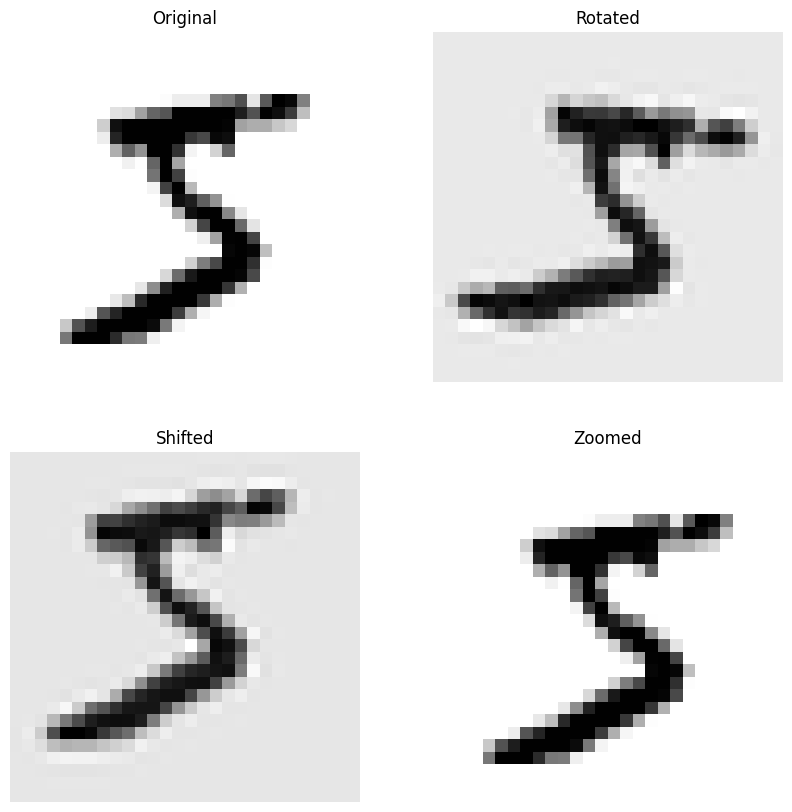

In [12]:
original_image = data[0]
original_image = original_image.reshape(28, 28)

rotated_image = random_rotation(original_image)
shifted_image = random_shift(original_image)
zoomed_image = random_zoom(original_image)

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0, 0].imshow(original_image, cmap='binary')
axes[0, 0].set_title('Original')
axes[0, 0].axis('off')

axes[0, 1].imshow(rotated_image, cmap='binary')
axes[0, 1].set_title('Rotated')
axes[0, 1].axis('off')

axes[1, 0].imshow(shifted_image, cmap='binary')
axes[1, 0].set_title('Shifted')
axes[1, 0].axis('off')

axes[1, 1].imshow(zoomed_image, cmap='binary')
axes[1, 1].set_title('Zoomed')
axes[1, 1].axis('off')

plt.show()

In [13]:
# Implement augmentation helper
def augment_image(image):
  np.random.seed(42)

  image = random_rotation(image)
  image = random_shift(image)
  image = random_zoom(image)

  new_size = image.shape[0]

  if new_size > 28:
    start = (new_size - 28) // 2
    end = start + 28
    image = image[start:end, start:end]
  else:
    padding = (28 - new_size) // 2
    image = np.pad(image, ((padding, padding), (padding, padding)),
                   mode='constant', constant_values=0)

  return image[:28, :28]

(28, 28)


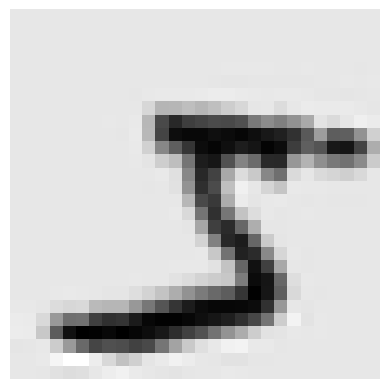

In [14]:
# Show a sample of augmented image
image = data[0]
image = image.reshape(28, 28)
augmented_image = augment_image(image)
plt.imshow(augmented_image, cmap='binary')
plt.axis('off')
print(augmented_image.shape)
plt.show()

In [15]:
#
# Data Preprocessing
#

data = data.astype(np.float32)
data = data / 255.0
labels = labels.astype(np.int32)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [16]:
#
# Perform data augmentation for each image in training set
#

num_augmentations_per_image = 2
X_train_augmented = []
y_train_augmented = []

for data, label in zip(X_train, y_train):
  image = data.reshape(28, 28)

  for _ in range(num_augmentations_per_image):
    augmented_image = augment_image(image)
    X_train_augmented.append(augmented_image.flatten())
    y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)
print(X_train_augmented.shape, y_train_augmented.shape)

(112000, 784) (112000,)


In [17]:
# Combine original train set with augmented train set
X_train_combined = np.concatenate((X_train, X_train_augmented))
y_train_combined = np.concatenate((y_train, y_train_augmented))
print(X_train_combined.shape, y_train_combined.shape)

(168000, 784) (168000,)


In [18]:
#
# Train and evaluate the KNeighborsClassifier model
#

knn_model = KNeighborsClassifier(n_neighbors=5, weights='uniform', n_jobs=-1)
knn_model.fit(X_train_combined, y_train_combined)

y_pred = knn_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1343
           1       0.94      1.00      0.97      1600
           2       0.97      0.96      0.97      1380
           3       0.96      0.96      0.96      1433
           4       0.97      0.96      0.96      1295
           5       0.97      0.95      0.96      1273
           6       0.98      0.98      0.98      1396
           7       0.96      0.96      0.96      1503
           8       0.99      0.92      0.96      1357
           9       0.95      0.96      0.95      1420

    accuracy                           0.97     14000
   macro avg       0.97      0.97      0.97     14000
weighted avg       0.97      0.97      0.97     14000



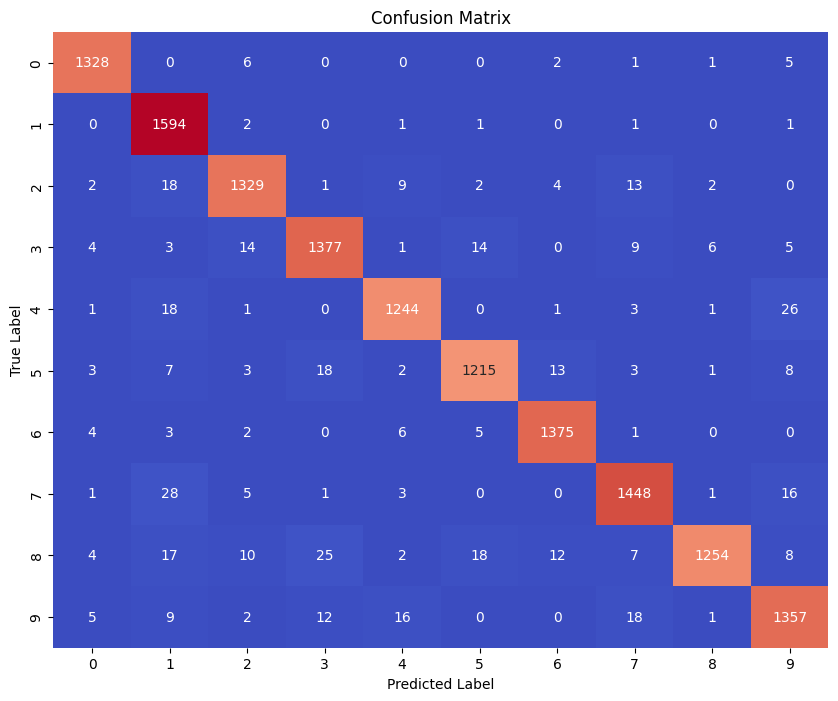

In [19]:
import seaborn as sns

# Visualize the Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='coolwarm', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

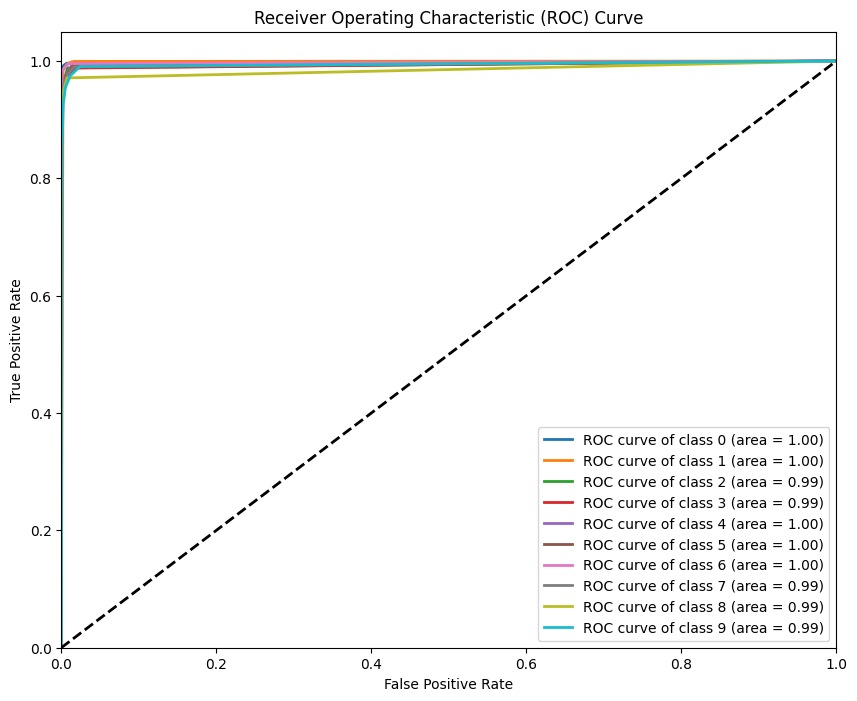

In [20]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Get predicted probabilities for each class
y_score = knn_model.predict_proba(X_test)

# Binarize the true labels for one-vs-rest ROC
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpl = dict()
roc_auc = dict()
for i in range(n_classes):
  fpr[i], tpl[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
  roc_auc[i] = auc(fpr[i], tpl[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('tab10', n_classes)
for i in range(n_classes):
  plt.plot(fpr[i], tpl[i], color=colors(i), lw=2,
           label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [22]:
# Save the model
filename = "../models/knn_digit_recognition_model.pkl"
pickle.dump(knn_model, open(filename, "wb"))